In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def create_comparation_table_clustering(pred, X, labels, dict_class_types, class_label):
    ''' Create a dataframe with the values of all the features (denoted by X) and the label results
    of the clustering algorithm, plus class names (table denoted by yhat). Also, returns a comparision table
    with the presence of each class type with each cluster type, if present.
    
    Args:
        - pred (pd.DataFrame): class prediction result
        - X (pd.DataFrame): features dataset, input for prediction
        - labels (pd.Series): true labels of the original dataset
        - dict_class_types (dict): dict with keys being the true class number and values with names.
        - class_label (pd.DataFrame): dataframe with information about data classes (number and name)
        
    Returns:
        - yhat (pd.DataFrame): dataframe with all the feature values plus the results of the model
        - comp_table (pd.DataFrame): dataframe with the results of the clustering model, plus calculations of the presence.
        
        
    '''    
    
    # Create dataframe with features plus prediction values
    yhat = X.copy()
    yhat['cluster_label'] = pred
    yhat['class_label'] = labels
    yhat['class_name'] = yhat['class_label'].replace(dict_class_types)
    
    # Create comparision table with results
    check_labels_w_names = yhat.groupby(['class_label','cluster_label']).size().reset_index()
    check_labels_w_names['class_name'] = check_labels_w_names['class_label'].replace(dict_class_types)
    check_labels_w_names = check_labels_w_names.set_index(['class_name', 'class_label'])
    check_labels_w_names = pd.merge(check_labels_w_names.reset_index(), class_label[['Class_Number', 'Number_Of_Animal_Species_In_Class']], 
            'left', left_on = 'class_label', right_on = 'Class_Number')
    check_labels_w_names = check_labels_w_names.rename({'Number_Of_Animal_Species_In_Class': 'class_total_number',
                                                        0: 'cluster_total_number'}, axis = 1)
    check_labels_w_names['presence_relative_to_class'] = np.round(check_labels_w_names['cluster_total_number']/check_labels_w_names['class_total_number'],3)
    comp_table = check_labels_w_names.set_index(['class_name', 'class_label'])

    return yhat, comp_table

In [ ]:
def compute_distance_matrix(centroids_clusters, centroids_classes):
    """ 
    Calculation of the distance between two vectors.
    
    Args:
        centroids_clusters (pd.DataFrame): matrix of the centroids for each cluster.
        centroids_classes (pd.DataFrame): matrix of the centroids for each of the classes.
        
    Returns:
        dmatrix (pd.DataFrame): distance matrix between centroids of each cluster with each class.
    
    """

    distance_matrix = []
    for cluster in centroids_clusters.index:
        distance_cluster_list = []
        for class_centroid in centroids_classes.index:
            eu_distance = np.linalg.norm(centroids_clusters.loc[cluster] - centroids_classes.loc[class_centroid])
            distance_cluster_list.append(eu_distance)
            
        distance_matrix.append(distance_cluster_list)
        
    dmatrix = pd.DataFrame(distance_matrix,index = centroids_clusters.index, columns = centroids_classes.index)
        
    return dmatrix

In [112]:
def assign_clusters_distance(dmatrix):
    
    """
    Assign based on Euclidean distance between centroids the most similar cluster
    
    Args:
        dmatrix (pd.DataFrame): dataframe with cluster numbers as indexes and class labels as columns. Values are the distances
                                previously computed
    
    Returns:
        cluster_assignment (pd.Series):  assignment of each cluster for each class label.
    
    """

    cluster_assignment = dmatrix.idxmin()
    # print(len(dmatrix.columns))
    if len(cluster_assignment.unique()) != len(dmatrix.columns):
        print('There are repeated assignments for one or several classes!!!')
        
    # todo: create alg for assign based on most near centroid
    
    return cluster_assignment
    
    

# Data

In [3]:
zoo = pd.read_csv('../data/zoo.csv')
class_label = pd.read_csv('../data/class.csv')
zm = pd.read_pickle('../data/zoo_mod.pkl')

In [17]:
non_boolean_features = ['legs', 'class_type']
numerical_features = ['legs']
animal_names_column = ['animal_name']


col_set = set(list(zoo.columns))
boolean_features = col_set-set(non_boolean_features+animal_names_column)
boolean_features_w_class = col_set - set(numerical_features+animal_names_column)

dict_class_types = dict(zip(class_label['Class_Number'], class_label['Class_Type']))

# Modeling
- Let's see what we can do with baseline clustering models.
- Then, if needed, we will do more wrangling, feature engineering, PCA or other transformations to the data if the result isn't the best.

In [9]:
from sklearn.cluster import KMeans

- Prepare the data for input in algorithms

In [11]:
labels = zm['class_type']
X = zm.drop(['animal_name', 'class_type', 'class_names'], axis = 1).copy()


In [13]:
k = 7
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X)

- We have the centroids

In [15]:
kmeans.cluster_centers_[2]

array([-1.66533454e-16,  1.00000000e+00,  1.00000000e+00, -1.66533454e-16,
        8.00000000e-01,  5.00000000e-02,  4.50000000e-01,  1.11022302e-16,
        1.00000000e+00,  1.00000000e+00, -1.38777878e-17, -2.77555756e-17,
        2.00000000e+00,  1.00000000e+00,  1.50000000e-01,  3.00000000e-01,
        1.50000000e-01])

In [18]:
yhat, comp_table = create_comparation_table_clustering(y_pred, X, labels, dict_class_types, class_label)

- For the first run, we have pretty good results. Our model could clusterize correctly the Bird, Fish, Amphibian and Bug classes.
- We can see that for mammals, there's also a good presence on cluster label 2 (being 31 of this label), but we still have some missclasified clusters.
- Reptiles and Invertebrate, don't have the best result, but we can try doing some other things to increase even more the quality of our model.    

In [21]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                     3             1   
             1                        1                    30             1   
             1                        4                     1             1   
             1                        5                     7             1   
Bird         2                        2                    20             2   
Reptile      3                        0                     1             3   
             3                        4                     2             3   
             3                        6                     2             3   
Fish         4                        0                    13             4   
Amphibian    5                        4                     4             5   
Bug          6                        3                     8             6   
Invertebrate 7                        3                     4             7   
             7                        4                     2             7   
             7                        6                     4             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.073  
             1                            41                       0.732  
             1                            41                       0.024  
             1                            41                       0.171  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.200  
             3                             5                       0.400  
             3                             5                       0.400  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.400  
             7                            10                       0.200  
             7                            10                       0.400

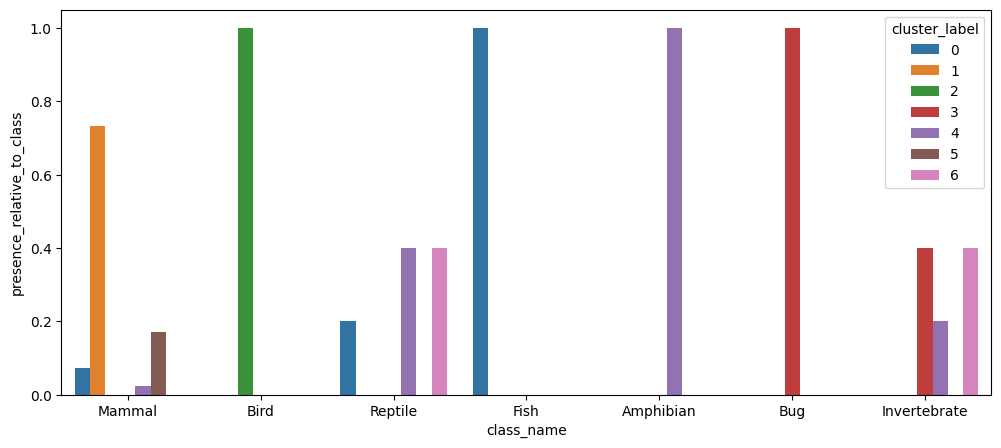

In [33]:
plt.figure(figsize = (12,5))

sns.barplot(data = comp_table.reset_index(),
            x = 'class_name', y = 'presence_relative_to_class', 
            hue = 'cluster_label', palette= 'tab10')

plt.show()

In [36]:
gb_clusters = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns).astype('float16').reset_index().rename({'index': 'label_cluster'}, axis = 1)
gb_clusters = gb_clusters.drop(['legs', 'label_cluster'], axis = 1)

- We see that for some classes, we calculated a very close approximation, comparing it with the mean values for each group and their respective feature.
- For example, for Mammals we see a strong correlation of features with the group 2 cluster label. Also Bird with cluster 1, Fish with group 3, Amphibian with group 6, Bug with group 0.
- Group 4 and 5 contains a weird mix of every feature. You can see it in the table we computed; label 4 is also present in the mammal label, while label 5 is around invertebrate and reptile classes.
- Maybe we can delete some features to make the model simpler and have better results?

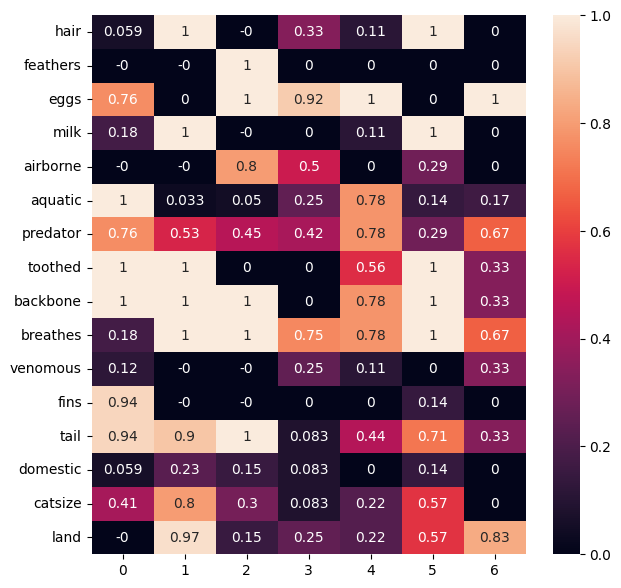

In [39]:
plt.figure(figsize = (7,7))

sns.heatmap(data = gb_clusters.T, annot = True)

plt.show()

In [56]:
centroids_classes = zm.drop(['class_type', 'animal_name'], axis = 1).groupby(['class_names']).mean()
centroids_clusters = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

# Get the distance between each cluster centroid to the centroid of the classes



In [114]:
dmatrix = compute_distance_matrix(centroids_clusters, centroids_classes)
assignment = assign_clusters_distance(dmatrix)
assignment

There are repeated assignments for one or several classes!!!


class_names
Amphibian       4
Bird            2
Bug             3
Fish            0
Invertebrate    4
Mammal          1
Reptile         2
dtype: int64

- We'll first try with these classes: predator, catsize, venomous, domestic
- Why these features? Mainly because they do not offer much information to the model. We can see that for each class the presence of each of these features do not represent critically many classes. (todo: explain this better)

## DBSCAN

In [115]:
from sklearn.cluster import DBSCAN

In [119]:
# todo: method for getting eps and min_sample, not arbitrary
dbsc = DBSCAN(eps = 1,min_samples = 4).fit_predict(X)
print(dbsc)

print(f'Unique values: {len(set(dbsc))}')

[ 0  0  1  0  0  0  0  1  1  0  0  2  1 -1  5  5  2  0  1 -1  2  2  0  2
 -1  3  3 -1  0 -1  4  0 -1  2  1  0  0  2  1  4  4 -1  4  2  0  0  5  0
 -1  0  0  4  3 -1  0  0 -1  2 -1  2  1  1 -1 -1  0  0 -1  0  0  0  0 -1
 -1  1 -1 -1 -1 -1  2  2 -1 -1  1  2 -1  5  1  2 -1  3 -1 -1  1 -1  0  2
 -1  4  0 -1  2]
Unique values: 7


In [120]:
yhat, comp_table = create_comparation_table_clustering(dbsc, X, labels, dict_class_types, class_label)

In [130]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                       -1                    12             1   
             1                        0                    29             1   
Bird         2                       -1                     4             2   
             2                        2                    16             2   
Reptile      3                       -1                     5             3   
Fish         4                        1                    13             4   
Amphibian    5                        3                     4             5   
Bug          6                       -1                     2             6   
             6                        4                     6             6   
Invertebrate 7                       -1                     6             7   
             7                        5                     4             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.293  
             1                            41                       0.707  
Bird         2                            20                       0.200  
             2                            20                       0.800  
Reptile      3                             5                       1.000  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       0.250  
             6                             8                       0.750  
Invertebrate 7                            10                       0.600  
             7                            10                       0.400

In [128]:
centroids_clusters = yhat.drop(['class_name', 'class_label'], axis = 1).groupby(['cluster_label']).mean()

In [129]:
dmatrix = compute_distance_matrix(centroids_clusters, centroids_classes)
assignment = assign_clusters_distance(dmatrix)
assignment

class_names
Amphibian       3
Bird            2
Bug             4
Fish            1
Invertebrate    5
Mammal          0
Reptile        -1
dtype: int64

## Second run
- WIP

In [ ]:
k = 7
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X.drop(['predator', 'catsize', 'venomous', 'domestic'], axis = 1))

In [ ]:
yhat, comp_table = create_comparation_table_clustering(y_pred, X, labels, dict_class_types, class_label)

- Our model keeps on labelling classes that dont correspond, especially on mammals, invertrebates and reptiles.

In [ ]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                    31             1   
             1                        1                     3             1   
             1                        5                     7             1   
Bird         2                        2                    20             2   
Reptile      3                        1                     3             3   
             3                        3                     2             3   
Fish         4                        1                    13             4   
Amphibian    5                        3                     4             5   
Bug          6                        6                     8             6   
Invertebrate 7                        1                     4             7   
             7                        3                     2             7   
             7                        4                     4             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.756  
             1                            41                       0.073  
             1                            41                       0.171  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.600  
             3                             5                       0.400  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.400  
             7                            10                       0.200  
             7                            10                       0.400

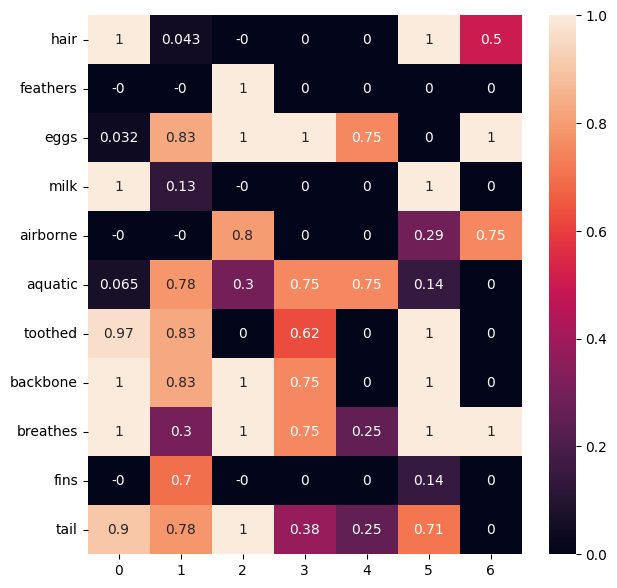

In [ ]:
plt.figure(figsize = (7,7))

sns.heatmap(pd.DataFrame(np.round(kmeans.cluster_centers_,3), columns = X.drop(['predator', 'catsize', 'venomous', 'domestic'], axis = 1).columns).drop('legs', axis = 1).T, annot = True)

plt.show()

- What about if we drop the same columns?

In [ ]:
dbsc = DBSCAN(eps = 1.5,min_samples = 5).fit_predict(X.drop(['predator', 'catsize', 'venomous', 'domestic'], axis = 1))
print(dbsc)

print(f'Unique values: {len(set(dbsc))}')

yhat, comp_table = create_comparation_table_clustering(dbsc, X.drop(['predator', 'catsize', 'venomous', 'domestic'], axis = 1), 
                                                       labels, dict_class_types, class_label)

[ 0  0  1  0  0  0  0  1  1  0  0  2  1 -1 -1  3  2  0  1 -1  2  2  0  2
  3  4  4  5  0  5  3  0  5  2  1  0  0  2  1  3  3  2  3  2  0  0  3  0
  0  0  0  3  4 -1  0  0  2  2  2  2  1  1 -1  0  0  0 -1  0  0  0  0  2
 -1  1 -1  5  1 -1  2  2 -1 -1  1  2  5  3  1  2  3  4  4  4  1  5  0  2
  5  3  0 -1  2]
Unique values: 7


In [ ]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                       -1                     3             1   
             1                        0                    31             1   
             1                        5                     7             1   
Bird         2                        2                    20             2   
Reptile      3                       -1                     2             3   
             3                        1                     1             3   
             3                        4                     2             3   
Fish         4                        1                    13             4   
Amphibian    5                        4                     4             5   
Bug          6                        3                     8             6   
Invertebrate 7                       -1                     7             7   
             7                        3                     3             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.073  
             1                            41                       0.756  
             1                            41                       0.171  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.400  
             3                             5                       0.200  
             3                             5                       0.400  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.700  
             7                            10                       0.300

In [ ]:
X

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1
97,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0
98,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1
99,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
